## Convolutional AutoEncoder for Fashion MNIST : Keras

In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tf.random.set_seed(42)
np.random.seed(42)    

### Step 1. Data -  target class : 10

In [19]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

4423680/4422102 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


In [20]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

### Step 2. Convolutional AE Model

In [21]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

print(conv_ae.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3, 3, 64)          23296     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________
None


### Step 3. Loss, Optimizer and Metric

In [22]:
# Step 3. Loss,Optimizer, Metric
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Step 4. Train the model

In [23]:
# Step 4. Train the model
history = conv_ae.fit(X_train, X_train, epochs=5, verbose=2,
                  validation_split=0.2)

Epoch 1/5
1500/1500 - 56s - loss: 0.3047 - rounded_accuracy: 0.9159 - val_loss: 0.2810 - val_rounded_accuracy: 0.9375
Epoch 2/5
1500/1500 - 55s - loss: 0.2768 - rounded_accuracy: 0.9400 - val_loss: 0.2785 - val_rounded_accuracy: 0.9351
Epoch 3/5
1500/1500 - 55s - loss: 0.2718 - rounded_accuracy: 0.9451 - val_loss: 0.2730 - val_rounded_accuracy: 0.9449
Epoch 4/5
1500/1500 - 56s - loss: 0.2690 - rounded_accuracy: 0.9480 - val_loss: 0.2691 - val_rounded_accuracy: 0.9499
Epoch 5/5
1500/1500 - 56s - loss: 0.2672 - rounded_accuracy: 0.9500 - val_loss: 0.2673 - val_rounded_accuracy: 0.9508


### Plot the Training/Validation loss

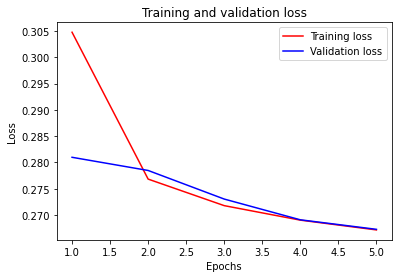

In [24]:
history_dict = history.history
#print(history_dict.keys())

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot images

In [25]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


### Show Reconstruction Images

In [26]:
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


### Save Imges

In [27]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Show Original and Reconstruected Images

Saving figure reconstruction_plot


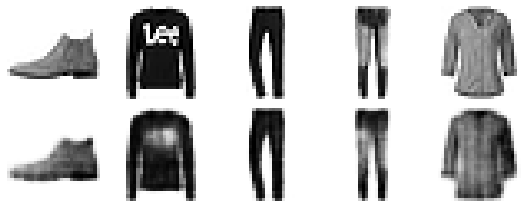

In [28]:
show_reconstructions(conv_ae)
save_fig("reconstruction_plot")

In [29]:
### Step 5. Test the Model

In [30]:
X_test_compressed = conv_encoder.predict(X_test)
X_test_compressed = X_test_compressed.reshape(-1, 3*3*64)

In [31]:
print(X_test.shape, X_test_compressed.shape)

(10000, 28, 28) (10000, 576)


### Image Visualization with TSNE

In [32]:
tsne = TSNE()
X_test_2D = tsne.fit_transform(X_test_compressed)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

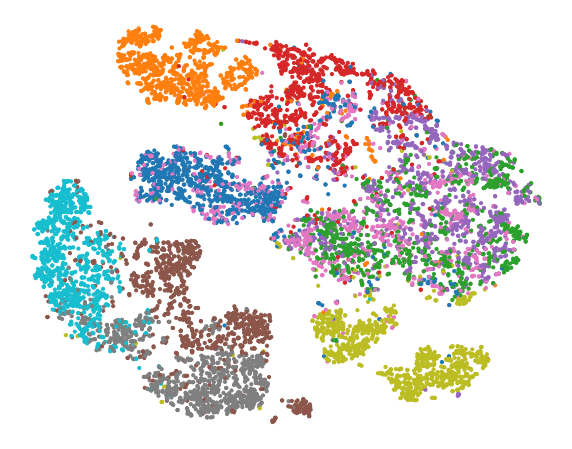

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap="tab10")
plt.axis("off")
plt.show()

### Plot Fashion MNIST on 2D Domain

Saving figure fashion_mnist_visualization_plot


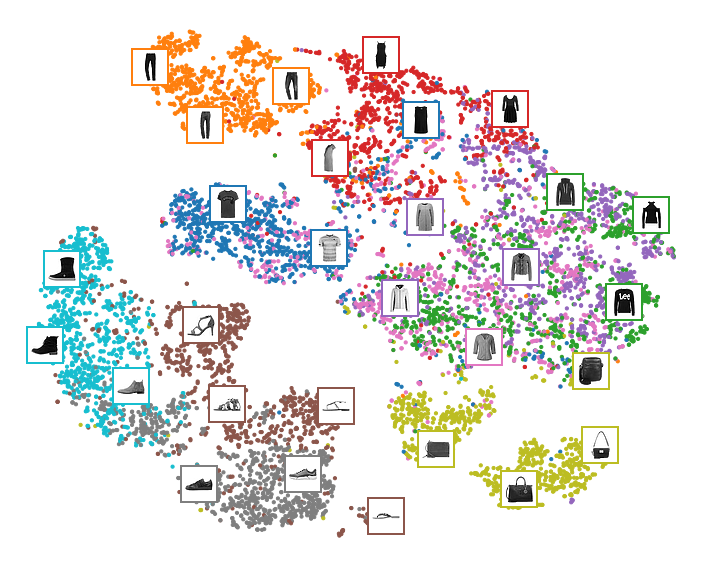

In [34]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()